In [1]:
!pip install torch --upgrade

    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59936000 @  0x7fe9295fb1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [2]:
!pip install torchvision --upgrade

    100% |████████████████████████████████| 61kB 5.4MB/s 
    100% |████████████████████████████████| 2.0MB 10.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import os
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
# MNIST is a classic dataset and it is included with torchvision

root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

# break up our data into groups of size 100
batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)


Processing...
Done!


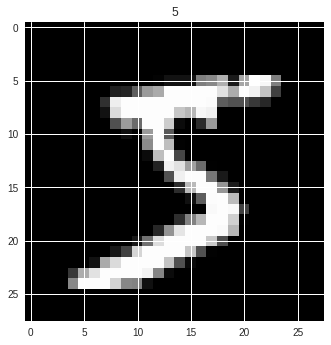

In [5]:
# plot example

plt.imshow(train_set.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_set.train_labels[0])
plt.show()

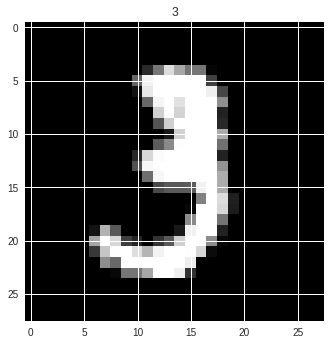

In [6]:
# plot example

plt.imshow(train_set.train_data[10].numpy(), cmap='gray')
plt.title('%i' % train_set.train_labels[10])
plt.show()

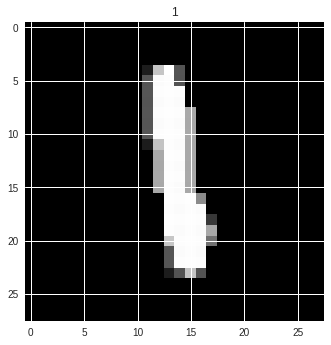

In [7]:
plt.imshow(train_set.train_data[200].numpy(), cmap='gray')
plt.title('%i' % train_set.train_labels[200])
plt.show()

In [0]:
class SimpleConv(nn.Module):
    def __init__(self, ic, oc, ks=3, drop=0.2, bn=True):
        super().__init__()
        self.conv = nn.Conv2d(ic, oc, ks, padding=(ks-1)//2)
        self.bn = nn.BatchNorm2d(oc, momentum=0.05) if bn else None
        self.drop = nn.Dropout2d(p=drop, inplace=False)
        self.act = nn.ReLU(True)
        
    def forward(self, x):
        x = self.conv(x)
        if self.bn: x = self.bn(x)
        return self.drop(self.act(x))

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)
      
net = nn.Sequential(
    SimpleConv(1, 64),
    SimpleConv(64, 128),
    SimpleConv(128, 128),
    SimpleConv(128, 128),
    nn.MaxPool2d(2),
    SimpleConv(128, 128),
    SimpleConv(128, 128),
    SimpleConv(128, 256),
    nn.MaxPool2d(2),
    SimpleConv(256, 256),
    SimpleConv(256, 256),
    nn.MaxPool2d(2),
    SimpleConv(256, 512),
    SimpleConv(512, 2048, ks=1, bn=False),
    SimpleConv(2048, 256, ks=1, bn=False),
    nn.MaxPool2d(2),
    SimpleConv(256, 256, bn=False, drop=0),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(256, 10)
)

In [0]:
# create our model
model = net

# if a GPU is available use it, otherwise just use the cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set the netowrk to run on the available device
model.to(device)

# define our graident decent optimized, here we add something called momentum to help avoid local mimimums 
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# defines our loss function
criterion = nn.CrossEntropyLoss()

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    # we will perform gradient decent on each batch
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    print('epoch: %d, iteration: %d, loss: %.6f' %
                  (epoch , i , running_loss / 600)) #print average loss
print('Finished Training')

epoch: 0, iteration: 599, loss: 0.689494


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97.49 %
